###### Assignemnt: Bayesian Convolutional Network with pyro

**Objective:** Implement, train and evaluate a Bayesian Lenet5 model on the MNIST dataset. 

**Requirements:**

- ~~Use `torchvision.datasets.MNIST` to obtain the training and test data. Only use digits 4 and 9 (discard the others)~~
- ~~Implement a bayesian neural network using `pyro` based on the Lenet5 convolutional architecture~~
- ~~Use a bernoulli likelihood, a diagonal normal for the approximate posterior and a diagonal normal prior. Use the Mean Field Trace ELBO~~
- Evaluate the performance of the BNN using precision/recall curves and uncertainty calibration plots [2, 3, 4]
- Study the influence of the scale of the prior and the initial scale of the approximate posterior
- Compare your best bayesian model with a Deterministic Lenet5 
- Discuss your results! 


**References**
1. https://www.kaggle.com/blurredmachine/lenet-architecture-a-complete-guide
2. https://arxiv.org/pdf/1703.04977.pdf (Section 5.1)
3. https://arxiv.org/pdf/2007.06823.pdf (Section 9)
4. https://arxiv.org/pdf/1706.04599.pdf 

**Deadline**

17:30, June 16th, 2021


In [261]:
#try to do a simple netowrk to visualize epistemic uncertanty
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from tqdm.notebook import tqdm
import torch
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pyro
display(pyro.__version__)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

np.random.seed(66)
torch.manual_seed(66)
pyro.set_rng_seed(66) # Fo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.6.0'

In [146]:
def getIdxForLabels(dataset, labels):
    mask = dataset.targets == labels[0]
    for label in labels[1:]:
        mask |= dataset.targets == label
    return np.where(mask)

def renameLabelsInOrder(dataset, labels):
    i=0
    for label in labels:
        dataset.targets[dataset.targets == label] = i
        i+=1

mnist_train = torchvision.datasets.MNIST('./Datasets', train=True, download=True,
                                        transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('./Datasets', train=False, download=True,
                                        transform=torchvision.transforms.ToTensor())
keepClasses = [4, 9]

train_idx = getIdxForLabels(mnist_train, keepClasses)
test_idx = getIdxForLabels(mnist_test, keepClasses)

train_dataset = Subset(mnist_train, train_idx[0])
test_dataset = Subset(mnist_test, test_idx[0])

renameLabelsInOrder(mnist_train, keepClasses)
renameLabelsInOrder(mnist_test, keepClasses)


print(len(train_dataset), " elements for training.")
print(len(test_dataset), " elements for testing.")

11791  elements for training.
1991  elements for testing.


<IPython.core.display.Javascript object>


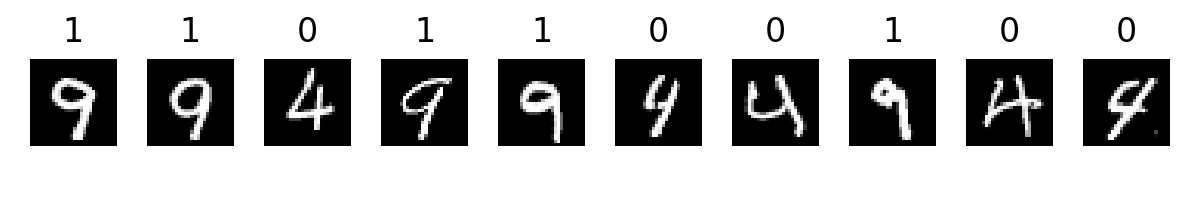

In [147]:
fig, ax = plt.subplots(1, 10, figsize=(6, 1), tight_layout=True)
for i in range(10):
    image, label = train_dataset[np.random.randint(len(train_dataset))]
    ax[i].imshow(image.numpy()[0, :, :], cmap=plt.cm.Greys_r)
    ax[i].axis('off')
    ax[i].set_title(label)

In [148]:
from torch.utils.data import DataLoader, SubsetRandomSampler

validationSize = 0.85
trainBatchSize = 128
validBatchSize = 128
testBatchSize = 256



idx = list(range(len(train_dataset)))
np.random.shuffle(idx)
split = int(validationSize*len(idx))

train_loader = DataLoader(train_dataset, batch_size=trainBatchSize, drop_last=False,
                          sampler=SubsetRandomSampler(idx[:split]))

valid_loader = DataLoader(train_dataset, batch_size=validBatchSize, drop_last=False,
                          sampler=SubsetRandomSampler(idx[split:]))

test_loader = DataLoader(test_dataset, batch_size=testBatchSize, drop_last=False,
                          shuffle=True)

In [149]:
COMPLETE_TEST_X = torch.tensor([])
COMPLETE_TEST_Y = torch.tensor([])
for X, y in test_loader:
    COMPLETE_TEST_X = torch.cat((COMPLETE_TEST_X, X), 0)
    COMPLETE_TEST_Y = torch.cat((COMPLETE_TEST_Y, y), dim=0)

<IPython.core.display.Javascript object>


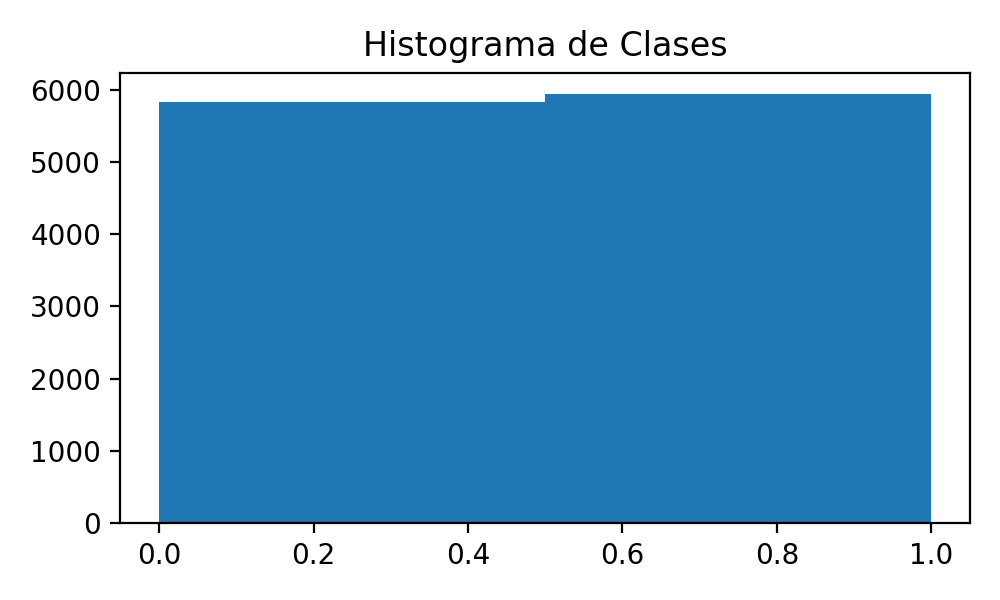

In [150]:
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.hist(train_dataset.dataset.targets[train_dataset.indices].numpy(), bins=2)
ax.set_title("Histograma de Clases");

# Deterministic Lenet5

In [151]:
from NeuralNetworks import Lenet5Deterministic
deterministicModel = Lenet5Deterministic()

In [152]:
deterministicLearningRate = 3e-4

loss = nn.BCELoss()
optimizer = torch.optim.Adam(deterministicModel.parameters(), lr=deterministicLearningRate)

def train_loop(dataloader, model, loss_fn, optimizer, n_samples):
    size = n_samples
    epochLoss = 0
    nSamples = 0
    for batch, (X, y) in enumerate((dataloader)):
        # Compute prediction and loss
        y = y.type(torch.float)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epochLoss += loss.item()
        nSamples += len(X)

    return epochLoss/nSamples
            

def valid_loop(dataloader, model, loss_fn, n_samples):
    size = n_samples
    test_loss, correct = 0, 0
    epochLoss = 0
    nSamples = 0
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y = y.type(torch.float)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
            epochLoss += test_loss
            nSamples += len(X)

    test_loss /= size
    correct /= size
    print(f"         Validation Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}", end='\r')
    return epochLoss/nSamples
    
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    print(size)
    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.float)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

<IPython.core.display.Javascript object>


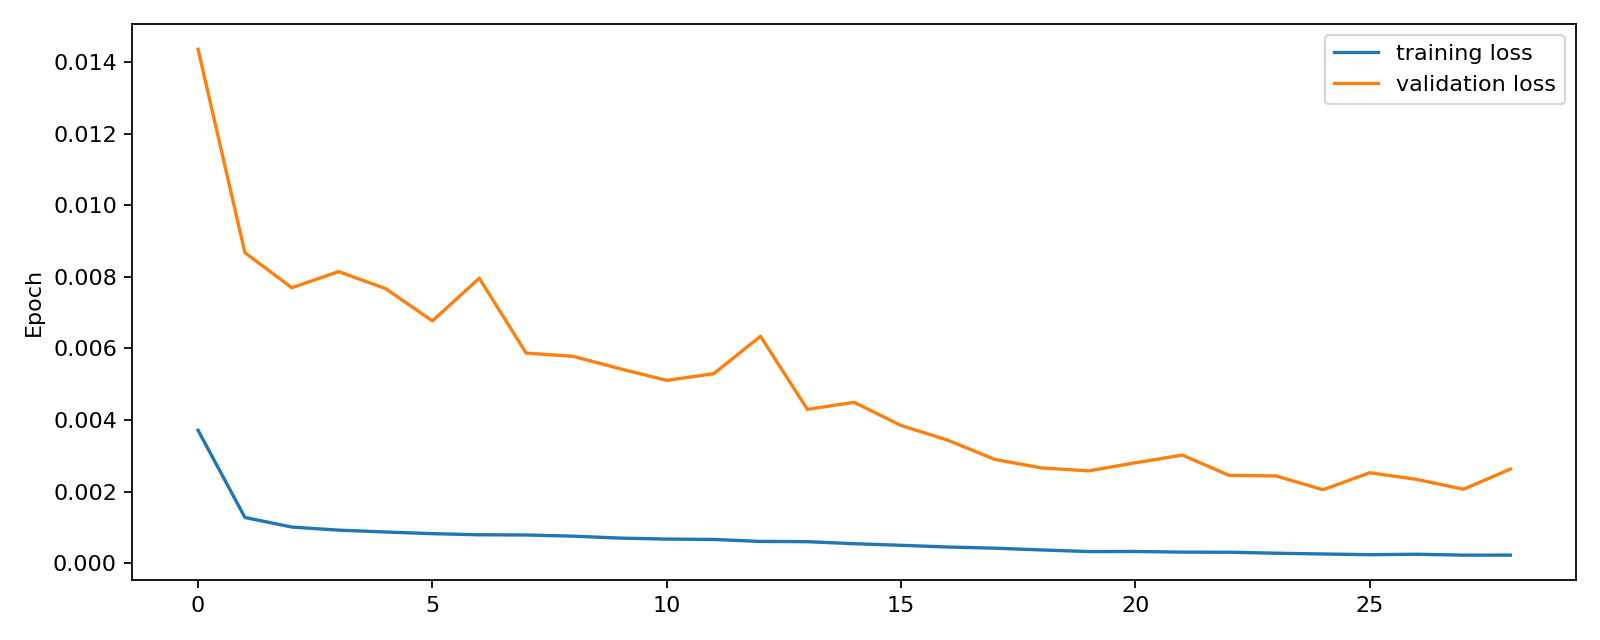

In [153]:
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True, dpi=80)

def update_plot(k, trainingLosses, validLosses):
    ax.cla()
    ax.plot(range(k), trainingLosses[:k], label="training loss")
    ax.plot(range(k), validLosses[:k], label="validation loss")

    #ax.set_yscale('log')
    ax.set_ylabel('Loss')
    ax.set_ylabel('Epoch')
    ax.legend()
    fig.canvas.draw()

In [154]:
from IPython.display import display, clear_output

epochs = 30

trainingLosses = np.zeros(epochs)
validLosses = np.zeros(epochs)

for t in range(epochs):
    #clear_output(wait=True)
    print(f"Epoch {t+1} ", end='\r')
    trainingLosses[t] = train_loop(train_loader, deterministicModel, loss, optimizer, split)
    validLosses[t] = valid_loop(valid_loader, deterministicModel, loss, len(train_loader.dataset)-split)
    update_plot(t, trainingLosses, validLosses)
    

test_loop(test_loader, deterministicModel, loss)


print("Done!")

1991     Validation Error: Accuracy: 98.9%, Avg loss: 0.000308
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.000101 

Done!


# Bayesian Lenet5

In [155]:
def getCollapsedDecision(samples, delta):
    #return (samples.mean(dim=0))
    return (samples.mean(dim=0).numpy() > delta).astype(int)

In [184]:
from NeuralNetworks import Lenet5Bayesian
bayesianModel = Lenet5Bayesian(prior_scale=1., isFEBayesian=True, prior_scaleFE=3.).to('cuda')


<IPython.core.display.Javascript object>


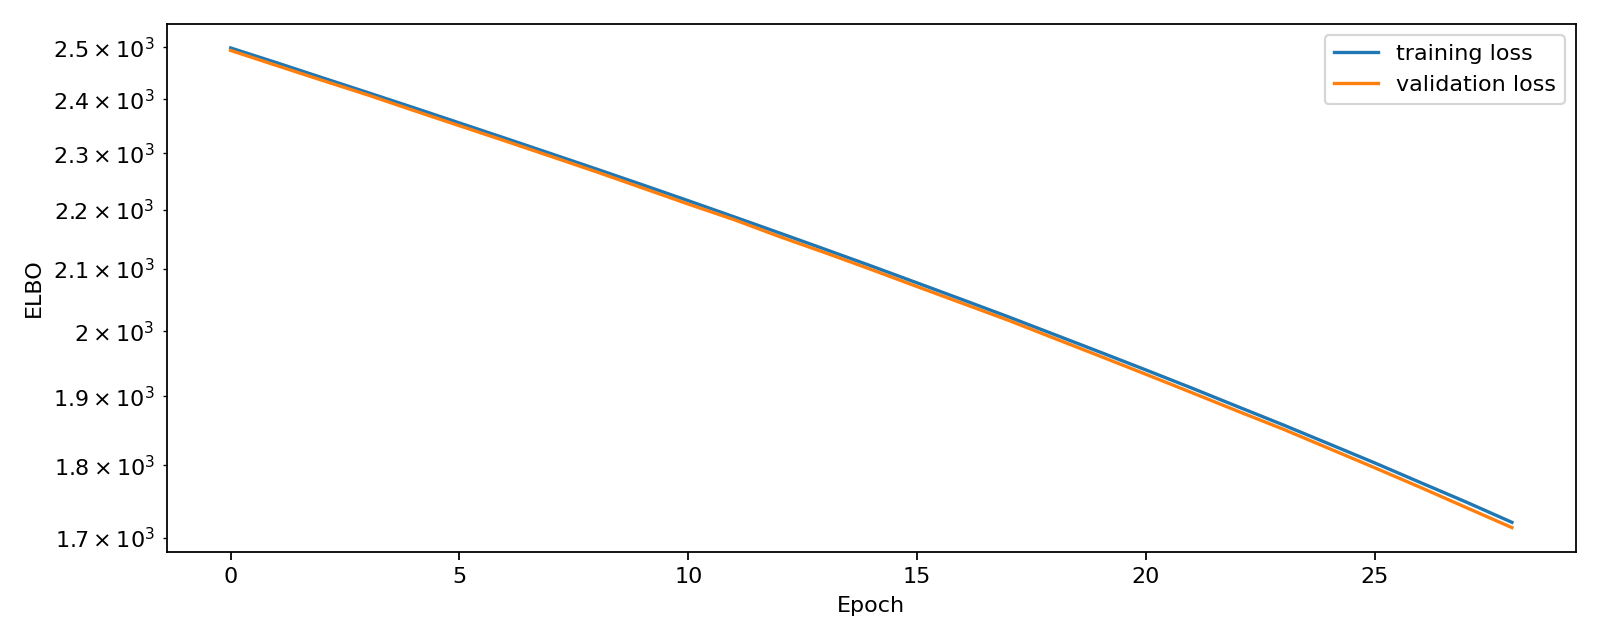

In [185]:
pyro.enable_validation(True)
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True, dpi=80)

def update_plot(k, trainingLosses, validLosses):
    ax.cla()
    ax.plot(range(k), trainingLosses[:k], label="training loss")
    ax.plot(range(k), validLosses[:k], label="validation loss")

    ax.set_yscale('log')
    ax.set_ylabel('ELBO')
    ax.set_xlabel('Epoch')
    ax.legend()
    fig.canvas.draw()

In [186]:
# Turn this on for additional debugging
pyro.enable_validation(False) 
pyro.clear_param_store() 
epochs = 30

# Create a guide
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(bayesianModel, init_scale=1e-3)
predictive = pyro.infer.Predictive(bayesianModel, guide=guide, num_samples=100)
# Create SVI object
svi = pyro.infer.SVI(bayesianModel, guide, 
                     optim=pyro.optim.ClippedAdam({'lr':1e-3, 'clip_norm':5.0}), # Optimizer
                     loss=pyro.infer.TraceMeanField_ELBO()) # Loss function 

epoch_loss = np.zeros(shape=(epochs,))
validLoss = np.zeros(shape=(epochs,))


for k in tqdm(range(len(epoch_loss))):
    acumloss = 0
    n = 0
    for X, y in train_loader:
        acumloss += svi.step(x=X, y=y.type(torch.float)) # Actual training step
        n+=(X.shape[0])
    epoch_loss[k] = acumloss/n

    #update_plot(k, epoch_loss, validLoss)   
    res = 0
    total = 0
    acumloss = 0
    for X, y in valid_loader:
        acumloss += svi.evaluate_loss(X, y.type(torch.float))
        ans = getCollapsedDecision(predictive(X)['obs'].detach(), 0.5)
        correct = accuracy_score(y, ans, normalize=False)
        res += correct
        total += X.shape[0]
    validLoss[k] = acumloss/total
    #print(epoch_loss, validLoss)
    update_plot(k, epoch_loss, validLoss)
    print("Validation Score:", res/total*100, end='\r')
 
            

  0%|          | 0/30 [00:00<?, ?it/s]

Cuando el modelo se entrena demasiado (ya sea durante muchas epocas o con un learning rate alto) el score baja a 0.5 por algun motivo. Que sucede cuando las redes bayesianas se sobreajustan?

In [251]:
predictive = pyro.infer.Predictive(bayesianModel, guide=guide, num_samples=500)

aciertos = 0
total = 0

with torch.no_grad():
    for X, y in tqdm(test_loader):
        out = predictive(X)['obs'].detach()
        ans = getCollapsedDecision(out, 0.5)
        aciertos += accuracy_score(y, ans, normalize=False)
        total += X.shape[0]

        
        print("Test score:", aciertos/total*100, end='\r')


  0%|          | 0/8 [00:00<?, ?it/s]

Los accuracy scores obtenidos por las redes en el set de pruebas son:
- Deterministica: 99.4%
- Bayesiana: ~99.2 %

# Evaluating the bayesian classifier

In [224]:
bayesianErrorsIdx = []
bayesianSamples = []

deterministicErrorsIdx = []
deterministicOutput = []

trueLabelsIdx = []

with torch.no_grad():
    out = predictive(COMPLETE_TEST_X)['obs'].detach()
    ans = getCollapsedDecision(out, 0.5)
    hitormiss = (ans == COMPLETE_TEST_Y.type(torch.long).numpy())
    bayesianErrorsIdx = np.where(hitormiss == False)[0]
    bayesianSamples = out.numpy().T[bayesianErrorsIdx]
        
with torch.no_grad():
    out = deterministicModel(COMPLETE_TEST_X)
    ans = (out.numpy() > 0.5).astype(int)
    #print(ans, COMPLETE_TEST_Y.type(torch.long).numpy())
    hitormiss = (ans == COMPLETE_TEST_Y.type(torch.long).numpy())
    deterministicErrorsIdx = np.where(hitormiss == False)[0]
    deterministicOutput = out[deterministicErrorsIdx]
    trueLabels = COMPLETE_TEST_Y[deterministicErrorsIdx]

# Evaluating the bayesian classifier

<IPython.core.display.Javascript object>


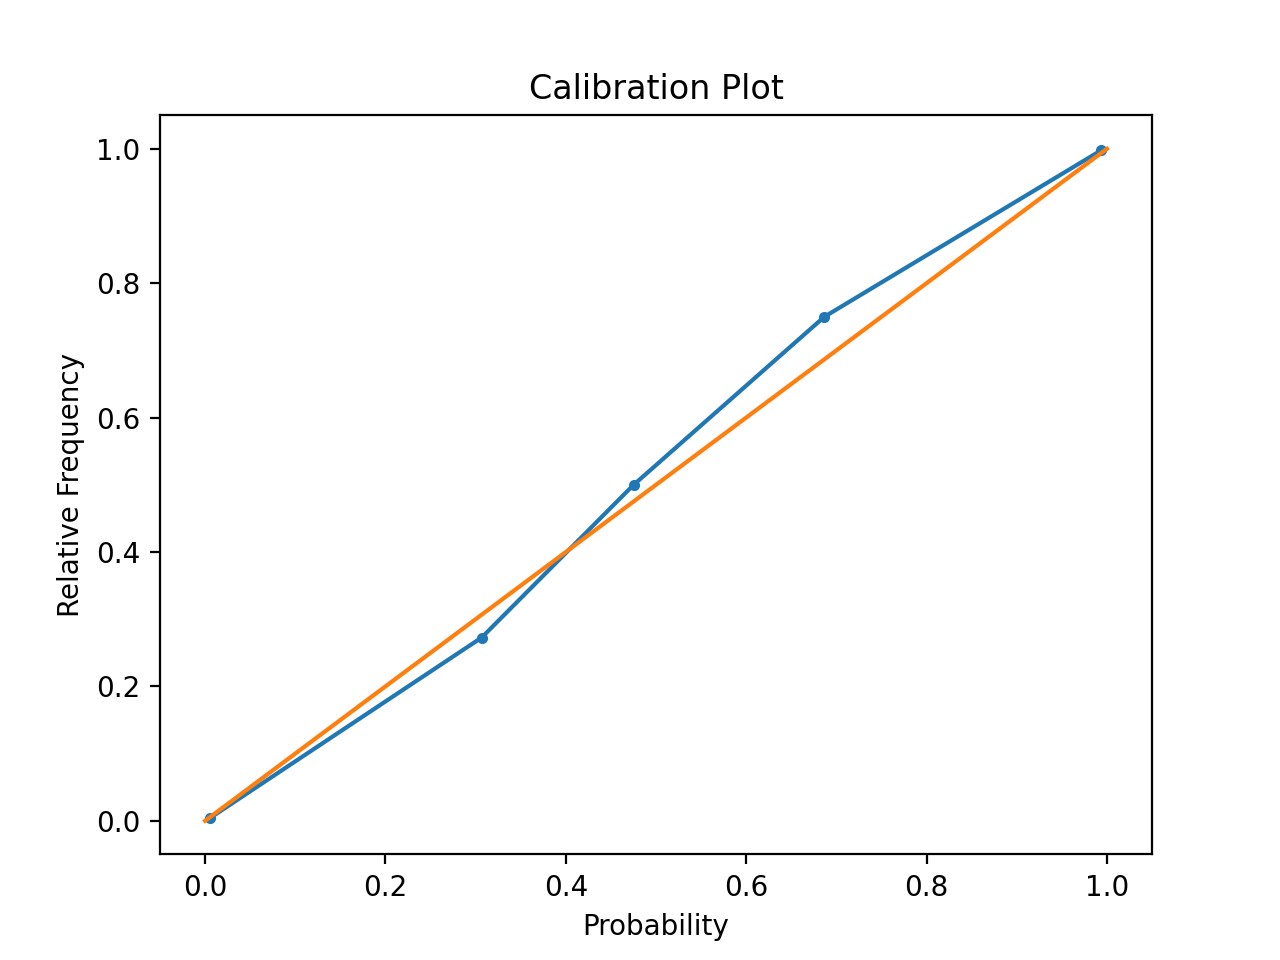

In [275]:
from sklearn.calibration import calibration_curve
samplesAvg = 0
with torch.no_grad():
    samplesAvg = predictive(COMPLETE_TEST_X)['obs'].detach().type(torch.float).mean(dim=0)
prob_true, prob_pred = calibration_curve(COMPLETE_TEST_Y, samplesAvg, n_bins=5)
fig, ax = plt.subplots()
ax.plot(prob_pred, prob_true, label="Clase", marker='.');
ax.set_xlabel("Probability")
ax.set_ylabel("Relative Frequency")
ax.set_title("Calibration Plot")
ax.plot(np.linspace(0, 1, 2),np.linspace(0, 1, 2), label='y = x');

De acuerdo al Uncertainty Calibration plot de arriba, el modelo bayesiano entrenado esta cercano a lo que se conoce como "Calibracion perfecta" pues la linea azul, que representa la confianza del modelo en las predicciones, esta muy cerca de la linea naranja, que reprenta una calibracion perfecta.

Entrando mas en detalle, el modelo parece tener una pequena inclinacion a estar "overconfident" acerca de las predicciones con baja probabilidad. Por el contrario, tambien para estar levemente "underconfident" en predicciones con una alta probabilidad. Esto significa que para predicciones en las que tiene baja probabilidad estima una probabilidad mayor de la que deberia y vice versa para el segundo caso.

<IPython.core.display.Javascript object>


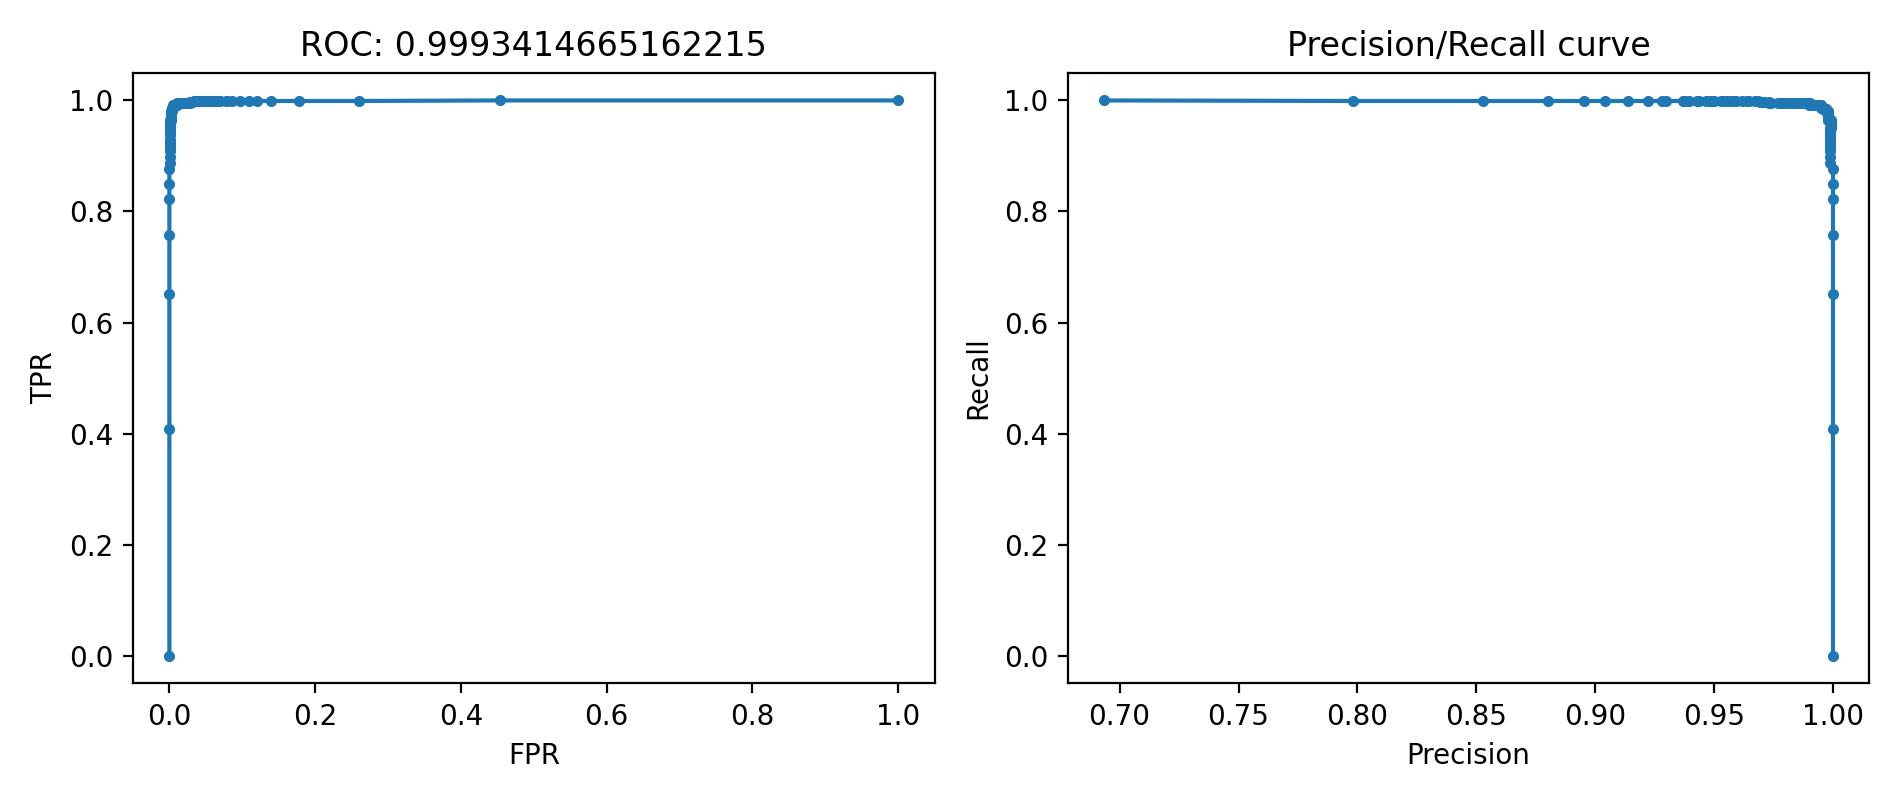

In [271]:
ns_fpr, ns_tpr, _ = roc_curve(COMPLETE_TEST_Y, samplesAvg)
pre, rec, _ = precision_recall_curve(COMPLETE_TEST_Y, samplesAvg)
roc = roc_auc_score(COMPLETE_TEST_Y, samplesAvg)

fig, ax = plt.subplots(1,2, figsize=(9.5, 4), tight_layout=True)
ax[0].plot(ns_fpr, ns_tpr, label="Clase", marker='.');
ax[0].set_xlabel("FPR")
ax[0].set_ylabel("TPR")
ax[0].set_title("ROC: {}".format(roc))

ax[1].plot(pre, rec, label="Clase", marker='.');
ax[1].set_xlabel("Precision")
ax[1].set_ylabel("Recall")
ax[1].set_title("Precision/Recall curve");


La curva FPR/TPR muestra resultados bastantes positivos. Con un ROC practicamente en 1. Esto quiere decir que al escoger el umbral correcto (0.5 en nuestro caso), practicamente no existe tradeoff entre clasificar correctamente las observaciones a coste de clasificar incorrectamente otras.
El grafico de la derecha muestra la curva Precision/Recall con resultados, nuevamente, bastante positivos. Con ambos valores cercanos a 1 con un umbral de 0.5.

In [278]:
print(classification_report(COMPLETE_TEST_Y, (samplesAvg.numpy() > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       982
         1.0       0.99      0.99      0.99      1009

    accuracy                           0.99      1991
   macro avg       0.99      0.99      0.99      1991
weighted avg       0.99      0.99      0.99      1991



El metodo `classification_report` de Scikit Learn nos entrega informacion mas concreta sobre las metricas de evaluacion. Aqui podemos ver que efectivamente con un umbral de $0.5$ el precision y recall para ambas clases es muy cercano a $1$. Ademas de un accuracy del $99\%$.

En conclusion, el clasificador binario bayesiano alcanzo un alto nivel de accuracy, ademas que estar casi perfectamente calibrado en cuando a su incerteza. Esto nos ayuda a tener la posibilidad de estudiar aquellos casos en los que el clasificador no este completamente seguro de una clase en particular.

# Arruinando el clasificador bayesiano

Como prior predictivo se utiliza:
$$p(x) -> \mathcal{N}(0, \sigma^2)$$

Al comienzo se entreno con $\sigma = 1$ para todos los parametros. Esto entrego resultados aceptables, con sobre un $90%$ de accuracy. Al probar con $\sigma \gt 10$, el rendimiento del modelo decae rapidamente hasta quedar atrapado en un $50%$ de accuracy. De hecho, cuando se utilizaban valores extremos, como un learning rate demasiado alto, el modelo tendia a optimizar para un $50%$ de accuracy. sin embargo, la grafica del ELBO mostrabaja una bajada continua. En cuanto a la calibracion, el mientras mas extremo sea el prior, la curva se hacia cada vez mas similar a una recta $y=0.5$. \
Finalmente lo que entrego mejores resultados, fue utilizar dos distribuciones normales con $\sigma$ distinto para cada una. Para las capas convolucionales (la seccion de feature extraction) se utilizo $\sigma=4$, mientras que para las capas lineales se utilizo $\sigma=1$.
Tambien se realizaron pruebas utilizando distribuciones para los parametros solo en las capas lineales, dejando las capas convolucionales de forma determinista. Este modelo tambien alcanzo buenisimos resultados. Con un entrenamiento mucho mas rapido que la version "fully-bayesian". Sin embargo, por temas de tiempo, no alcance a probar su incertidumbre en graficos de calibracion.

En cuanto a la escala inicial del posterior aproximado, para este caso se utilizo un valor de $0.001$. Al aumentar este valor a $0.1$ se obtiene buenas predicciones con un $95%$ de accuracy, sin embargo, el grafico de calibracion muestra un comportamiento mas exagerado, donde la curva no esta alineada con la recta $y=x$, en este caso existe sobreconfianza agresiva para probabilidades bajas, y por el contrario, 'underconfidence' mas agresiva para probabilidades altas

# Plotting error cases

## Deterministic first

Cantidad de clasificaciones erradas: 13


<IPython.core.display.Javascript object>


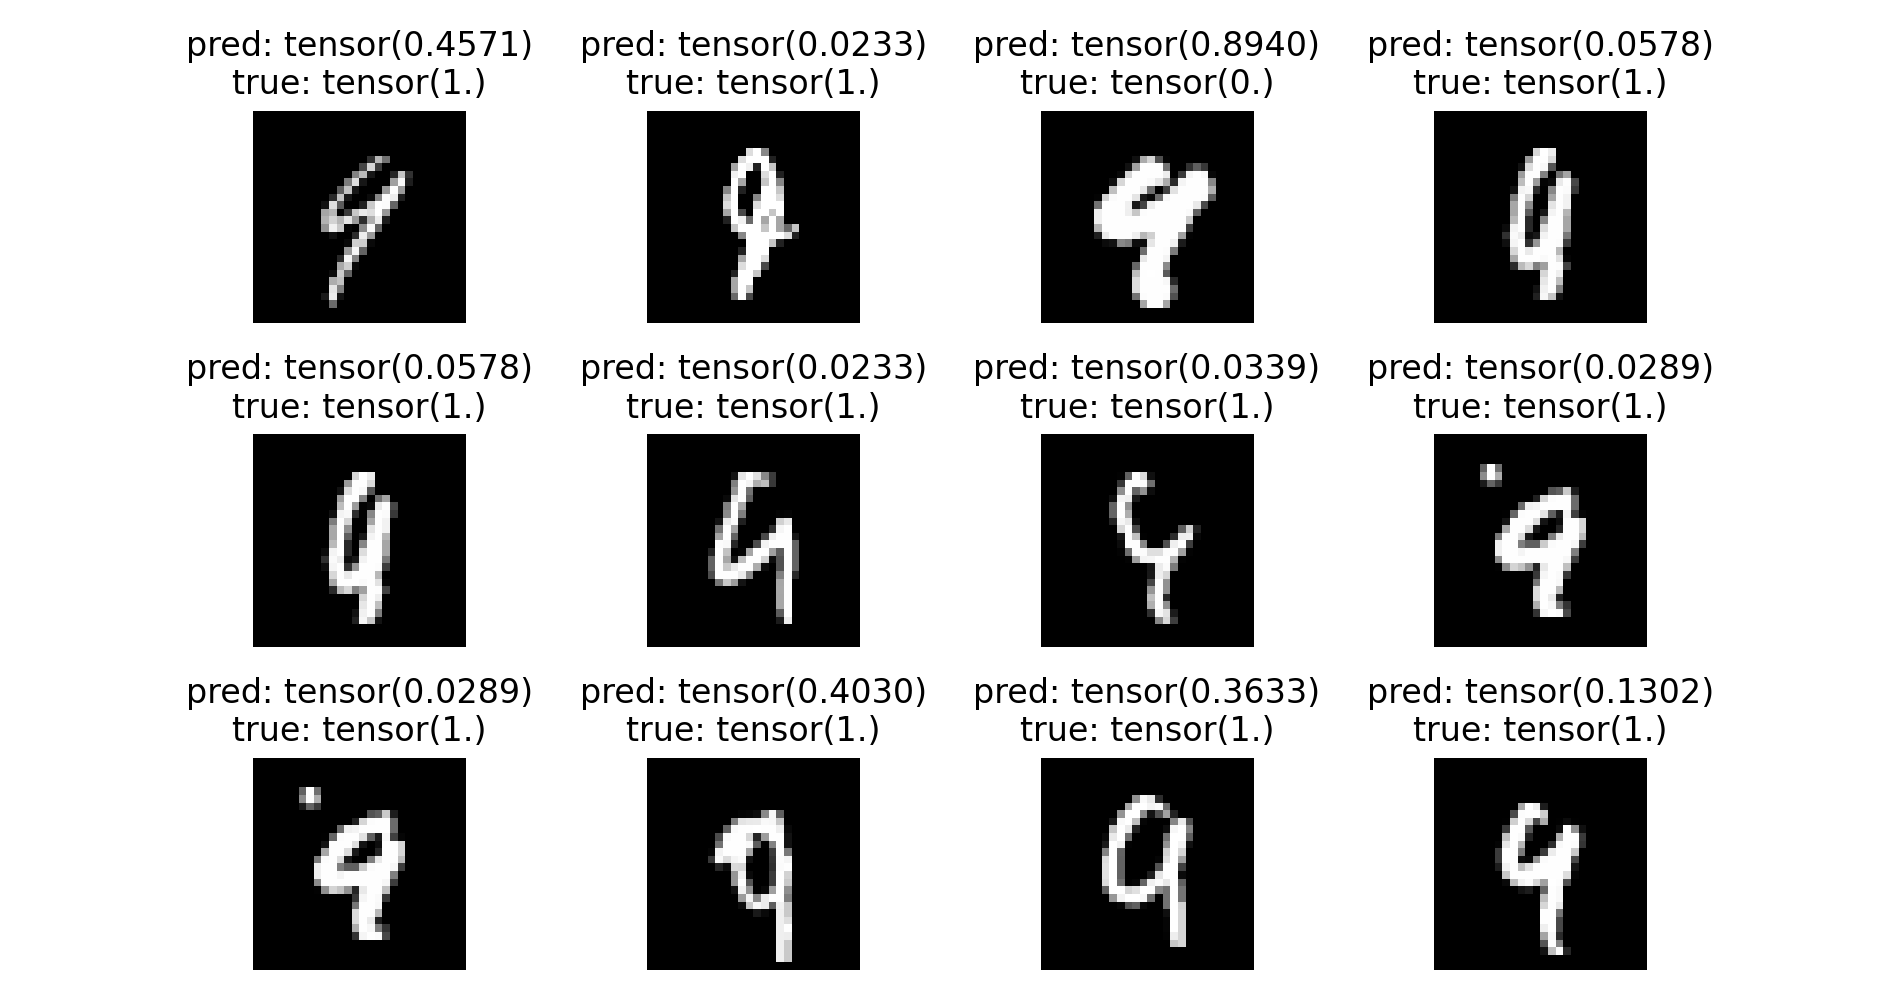

In [238]:
nerrors = len(deterministicErrorsIdx)
print("Cantidad de clasificaciones erradas:", nerrors)
rows = int(np.floor(np.sqrt(nerrors)))
cols = nerrors//rows
fig, ax = plt.subplots(rows, cols, figsize=(9.5, 5), tight_layout=True)
for i in range(rows):
    for j in range(cols):
        image = COMPLETE_TEST_X[deterministicErrorsIdx[i*rows+j]].squeeze(0).squeeze(0).unsqueeze(2)
        conf = deterministicOutput[i*rows+j]
        if nerrors>1:
            ax[i,j].imshow(image.numpy(), cmap=plt.cm.Greys_r)
            ax[i,j].axis('off')        
            ax[i,j].set_title("pred: "+str(conf) + "\ntrue: "+str(trueLabels[i*rows+j]))
        else:
            ax.imshow(image.numpy(), cmap=plt.cm.Greys_r)
            ax.axis('off')        
            ax.set_title("pred: "+str(conf) + "\ntrue: "+str(trueLabels[i*rows+j]))

## Now Bayesian

Cantidad de clasificaciones erradas: 15


<IPython.core.display.Javascript object>


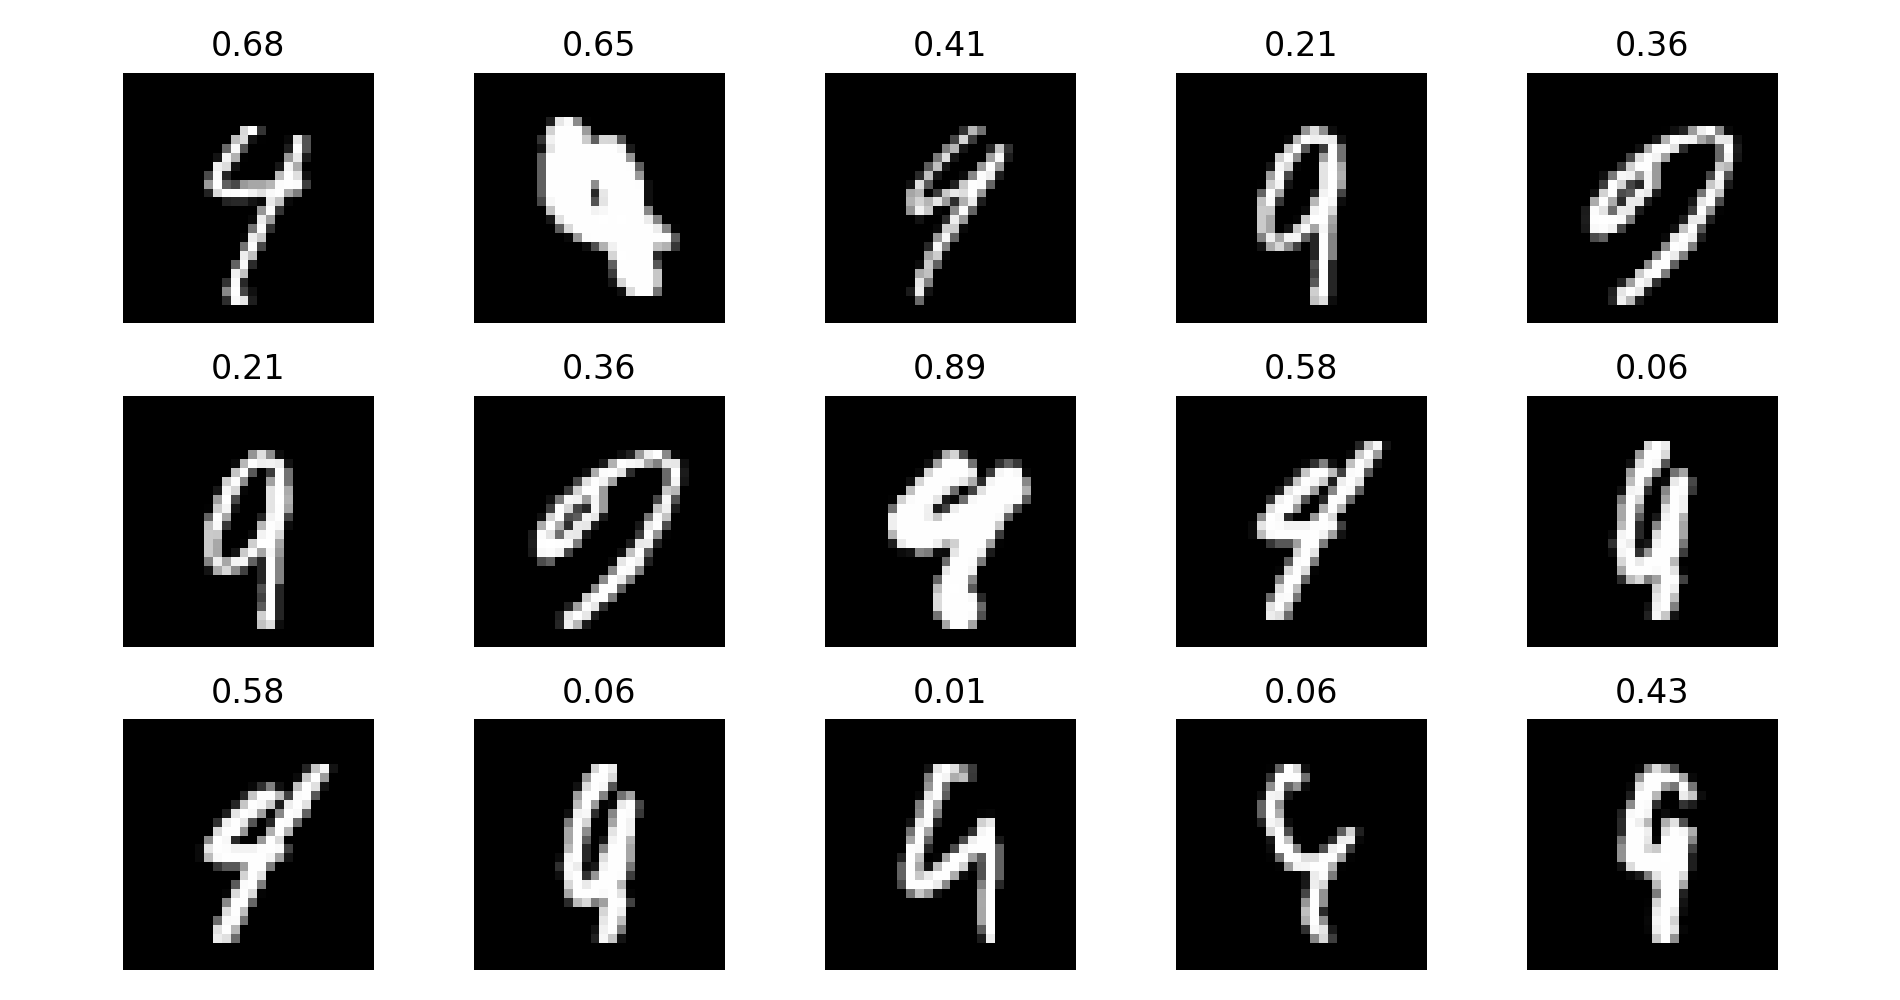

In [240]:
nerrors = len(bayesianErrorsIdx)
print("Cantidad de clasificaciones erradas:", nerrors)
rows = int(np.floor(np.sqrt(nerrors)))
cols = nerrors//rows
fig, ax = plt.subplots(rows, cols, figsize=(9.5, 5), tight_layout=True)
for i in range(rows):
    for j in range(cols):
        image = COMPLETE_TEST_X[bayesianErrorsIdx[i*rows+j]].squeeze(0).squeeze(0).unsqueeze(2)
        conf = np.average(bayesianSamples[i*rows+j])
        ax[i,j].imshow(image.numpy(), cmap=plt.cm.Greys_r)
        ax[i,j].axis('off')        
        ax[i,j].set_title(conf)

# Casos en los que ambos se equivocaron

Cantidad de clasificaciones erradas en comun: 7


<IPython.core.display.Javascript object>


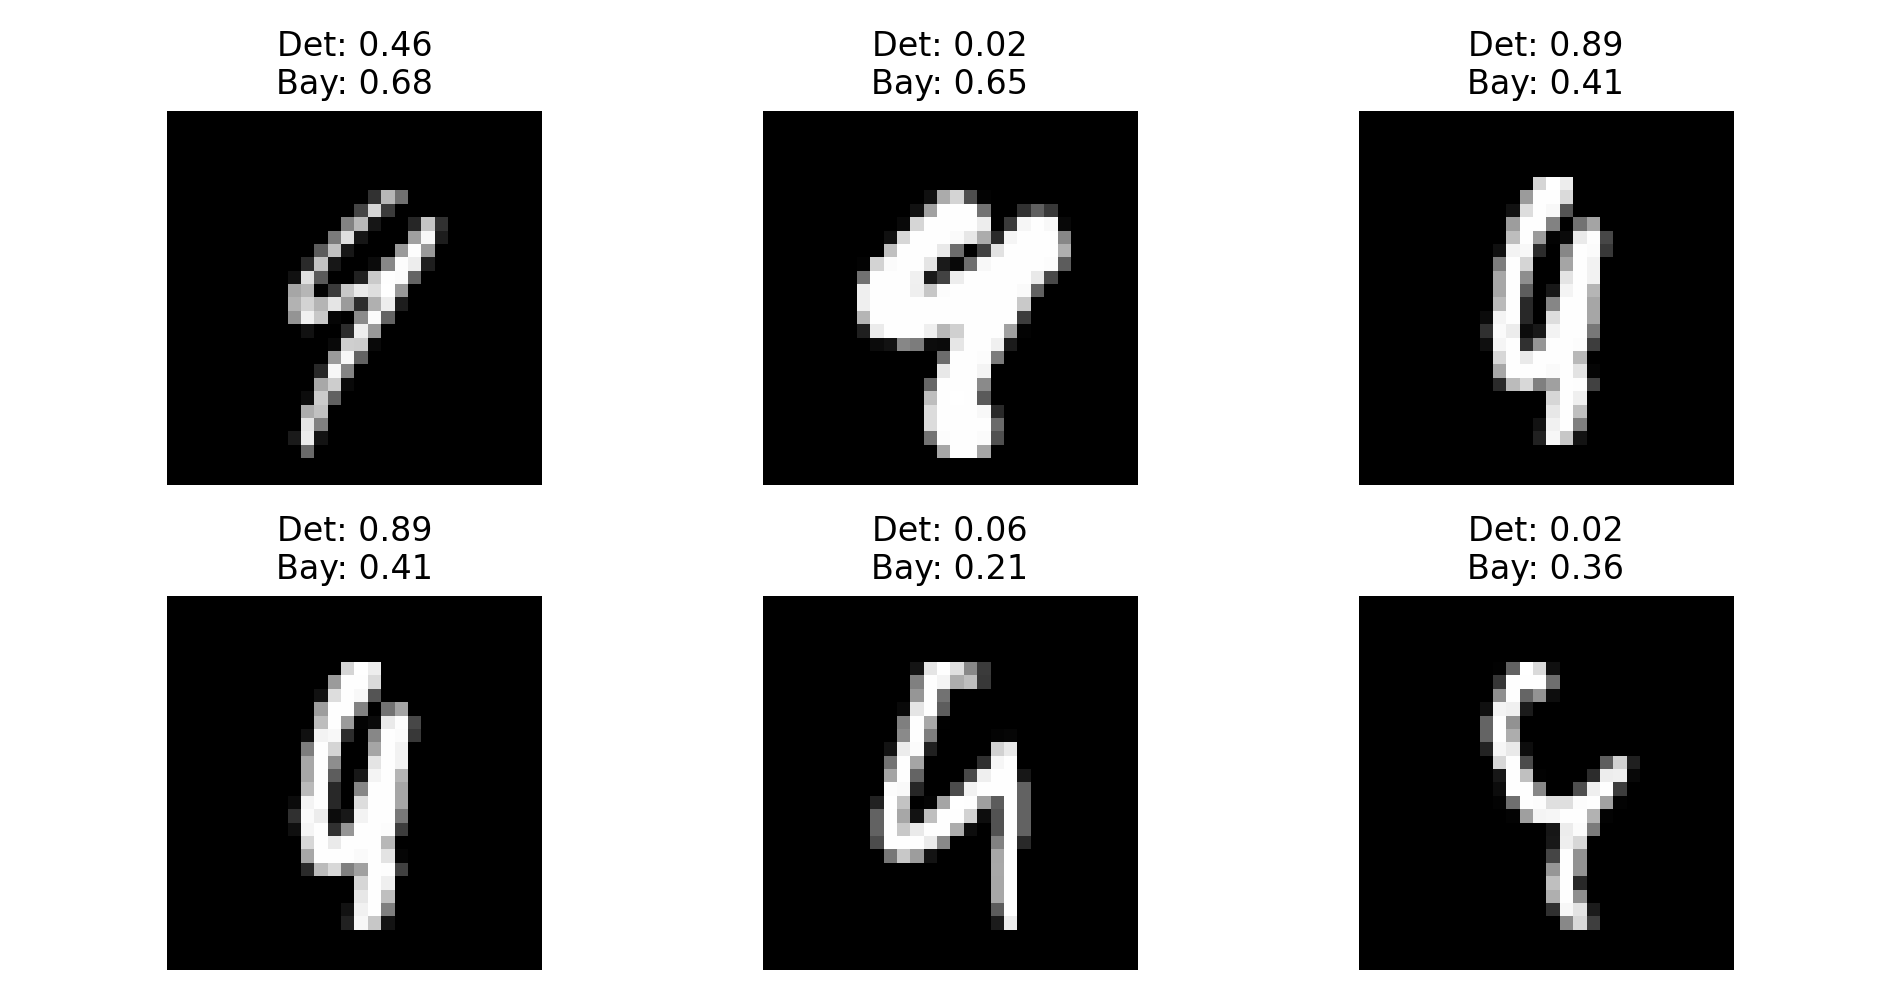

In [247]:
from collections import Counter
errIdx = list((Counter(bayesianErrorsIdx) & Counter(deterministicErrorsIdx)).elements())
nerrors = len(errIdx)
print("Cantidad de clasificaciones erradas en comun:", nerrors)
rows = int(np.floor(np.sqrt(nerrors)))
cols = nerrors//rows
fig, ax = plt.subplots(rows, cols, figsize=(9.5, 5), tight_layout=True)
for i in range(rows):
    for j in range(cols):
        image = COMPLETE_TEST_X[errIdx[i*rows+j]].squeeze(0).squeeze(0).unsqueeze(2)
        probBay = np.average(bayesianSamples[i*rows+j])
        probDet = deterministicOutput[i*rows+j]
        ax[i,j].imshow(image.numpy(), cmap=plt.cm.Greys_r)
        ax[i,j].axis('off')        
        ax[i,j].set_title("Det: " + str(np.round(probDet.item(), 2)) + "\nBay: " + str(probBay))

In [191]:
predictive = pyro.infer.Predictive(bayesianModel, guide=guide, num_samples=500)
bins = 5
#delta = 0.5
intervals = np.linspace(0.0, 1.0, bins)
frequency = np.zeros((bins))
total = np.zeros((bins))
with torch.no_grad():
    for X, y in tqdm(test_loader):
        samplesAvg = predictive(X)['obs'].detach().type(torch.float).mean(dim=0)
        for i, conf in enumerate(samplesAvg):
            ans = (torch.round(conf)).item()
            if ans==0:
                continue
            else:
                conf = 2*conf - 1.0
            for j, interval in enumerate(intervals):
                if conf < interval:
                    if ans == y[i].item():
                        frequency[j]+=1
                    total[j]+=1
                    break
                    

  0%|          | 0/8 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


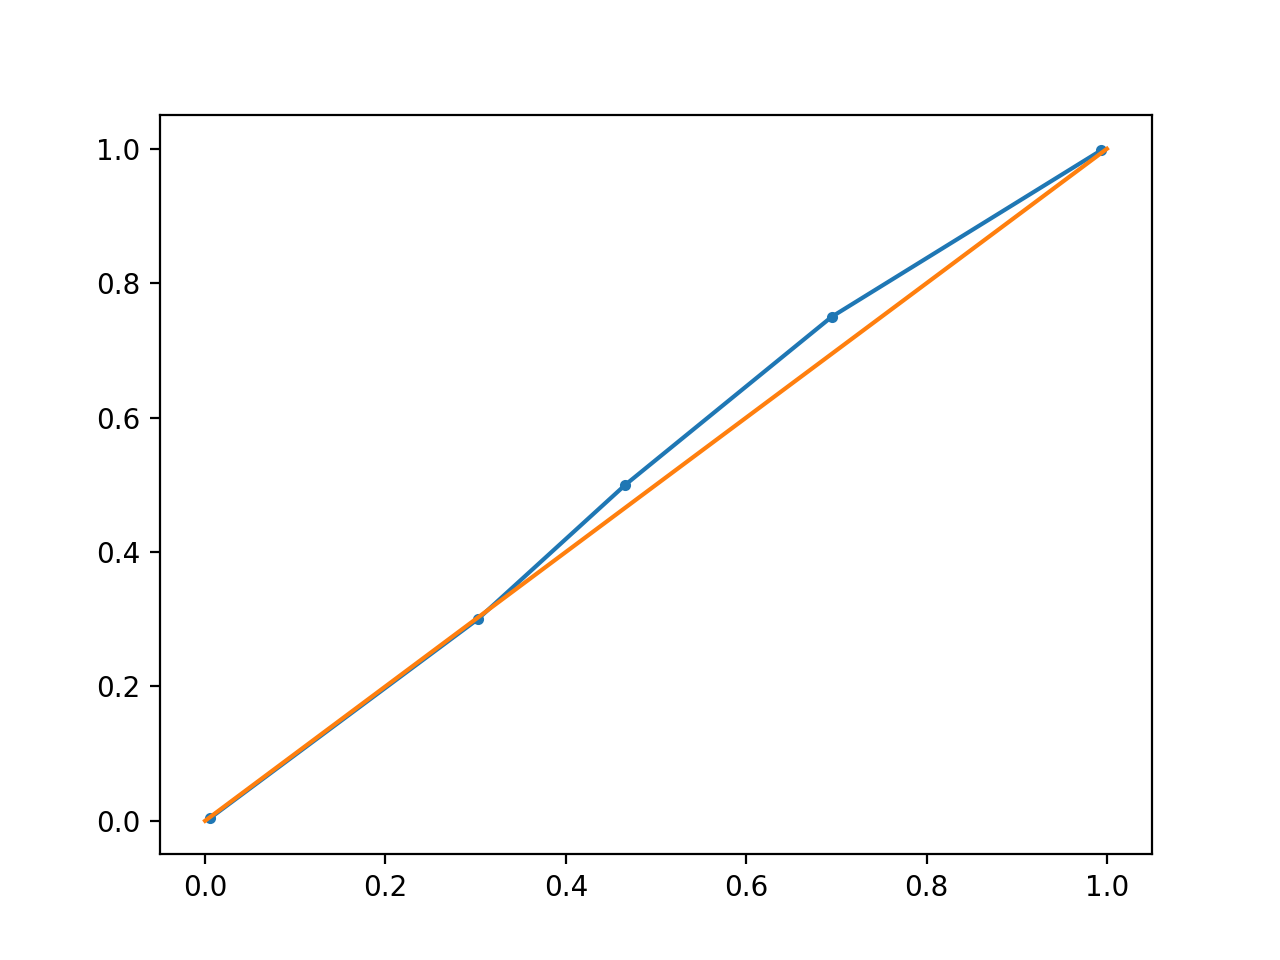

In [192]:
from sklearn.calibration import calibration_curve
samplesAvg = 0
with torch.no_grad():
    samplesAvg = predictive(COMPLETE_TEST_X)['obs'].detach().type(torch.float).mean(dim=0)
prob_true, prob_pred = calibration_curve(COMPLETE_TEST_Y, samplesAvg, n_bins=5)
fig, ax = plt.subplots()
ax.plot(prob_pred, prob_true, label="Clase", marker='.');
ax.plot(np.linspace(0, 1, 2),np.linspace(0, 1, 2), label='y = x')


In [193]:
print(prob_true.shape)

(5,)


In [194]:
freq = frequency/total
freq[np.isnan(freq)] = 0
freq


<ipython-input-194-e26e3c3a2883>:1: RuntimeWarning: invalid value encountered in true_divide
  freq = frequency/total


array([0.      , 0.75    , 0.7     , 1.      , 0.996337])

<IPython.core.display.Javascript object>


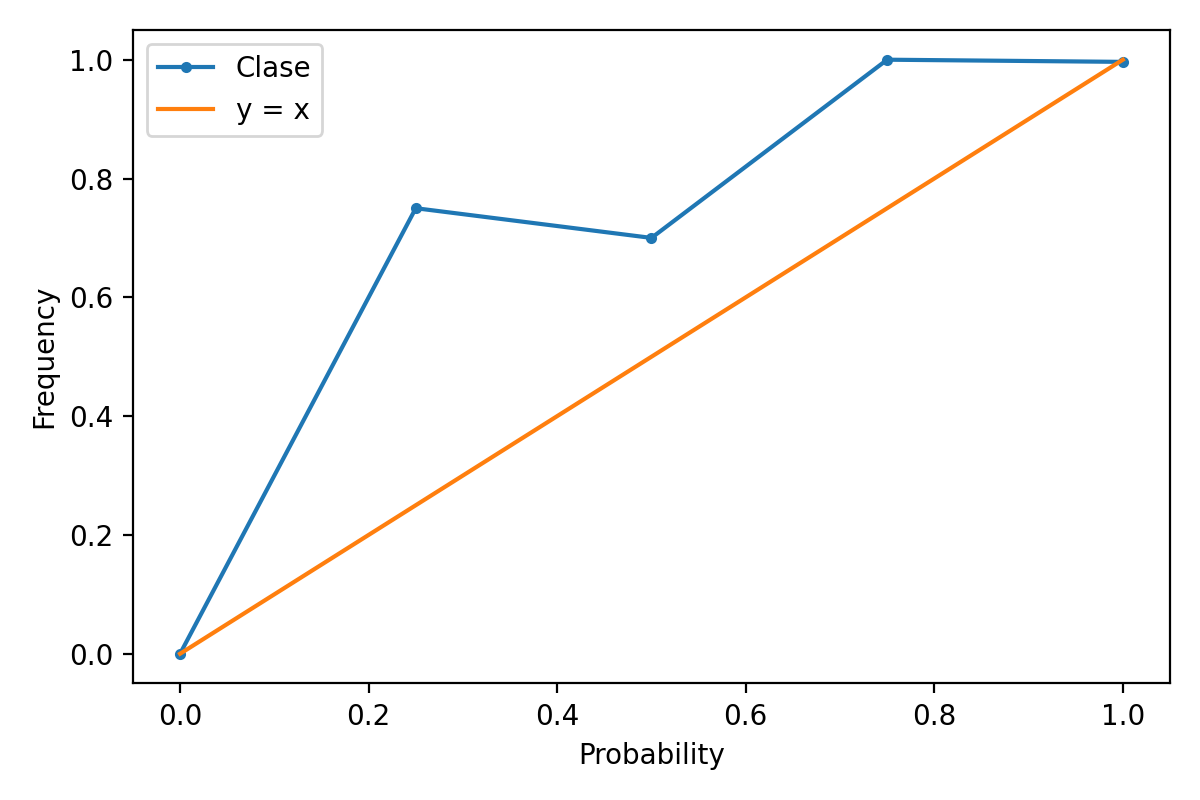

In [195]:
fig, ax = plt.subplots( figsize=(6,4), tight_layout=True)
ax.plot(intervals, freq, label="Clase", marker='.');
ax.plot(np.linspace(0, 1, 2),np.linspace(0, 1, 2), label='y = x')
ax.set_ylabel("Frequency")
ax.set_xlabel("Probability")
ax.legend()

In [196]:
from sklearn.metrics import confusion_matrix
predictive = pyro.infer.Predictive(bayesianModel, guide=guide, num_samples=100)


corr= 0
tot=0
with torch.no_grad():
    for X, y in tqdm(test_loader):
        out = predictive(X)['obs'].detach()
        ans = getCollapsedDecision(out, 0.5)
        corr += accuracy_score(y, ans, normalize=False)
        tot += X.shape[0]
print(corr/tot)

  0%|          | 0/8 [00:00<?, ?it/s]

0.9924660974384731


In [197]:
from sklearn.metrics import classification_report
print(classification_report(TOTALTESTY, TOTALTESTYHAT))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       982
         1.0       0.99      0.99      0.99      1009

    accuracy                           0.99      1991
   macro avg       0.99      0.99      0.99      1991
weighted avg       0.99      0.99      0.99      1991



In [298]:
from NeuralNetworks import Lenet5Bayesian
bayesianModel = Lenet5Bayesian(prior_scale=1., isFEBayesian=True, prior_scaleFE=3.).to('cuda')


<IPython.core.display.Javascript object>


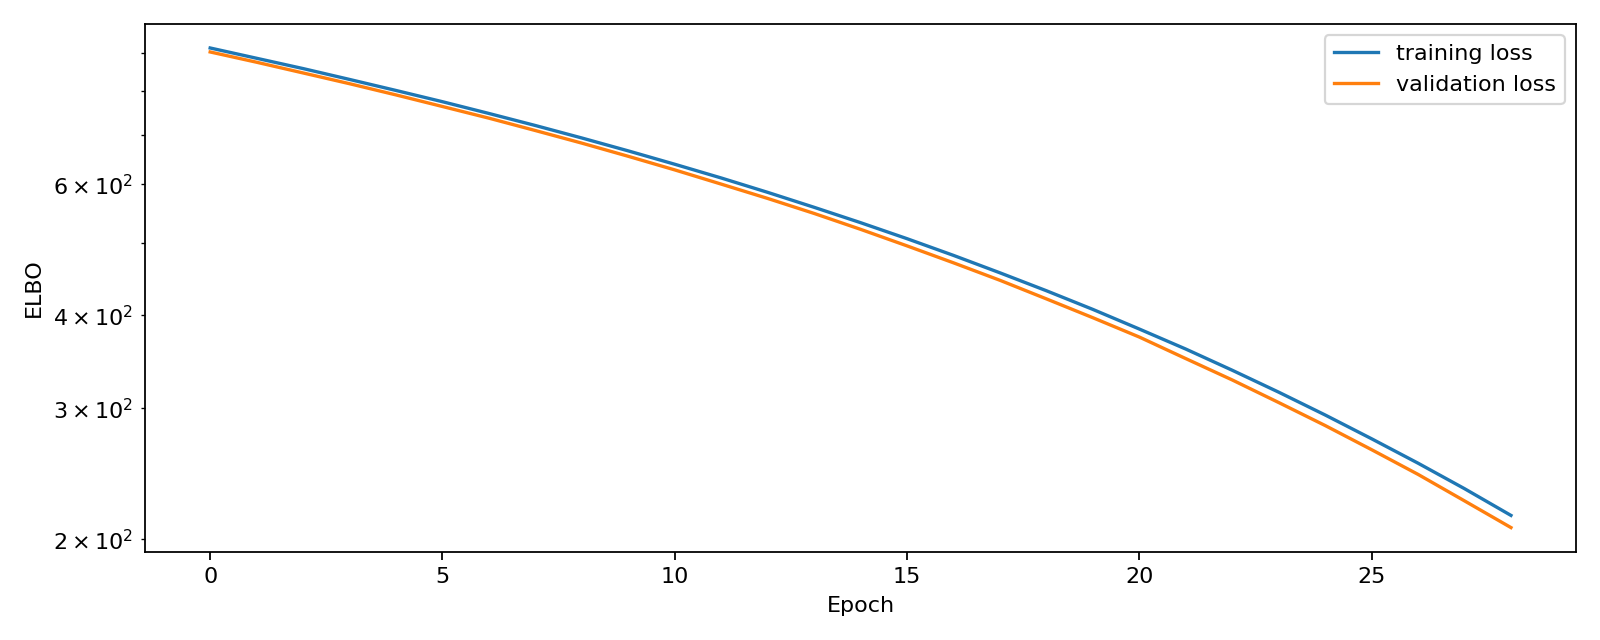

In [299]:
pyro.enable_validation(True)
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True, dpi=80)

def update_plot(k, trainingLosses, validLosses):
    ax.cla()
    ax.plot(range(k), trainingLosses[:k], label="training loss")
    ax.plot(range(k), validLosses[:k], label="validation loss")

    ax.set_yscale('log')
    ax.set_ylabel('ELBO')
    ax.set_xlabel('Epoch')
    ax.legend()
    fig.canvas.draw()

In [300]:
# Turn this on for additional debugging
pyro.enable_validation(False) 
pyro.clear_param_store() 
epochs = 30

# Create a guide
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(bayesianModel, init_scale=1e-1)
predictive = pyro.infer.Predictive(bayesianModel, guide=guide, num_samples=100)
# Create SVI object
svi = pyro.infer.SVI(bayesianModel, guide, 
                     optim=pyro.optim.ClippedAdam({'lr':1e-3, 'clip_norm':5.0}), # Optimizer
                     loss=pyro.infer.TraceMeanField_ELBO()) # Loss function 

epoch_loss = np.zeros(shape=(epochs,))
validLoss = np.zeros(shape=(epochs,))


for k in tqdm(range(len(epoch_loss))):
    acumloss = 0
    n = 0
    for X, y in train_loader:
        acumloss += svi.step(x=X, y=y.type(torch.float)) # Actual training step
        n+=(X.shape[0])
    epoch_loss[k] = acumloss/n

    #update_plot(k, epoch_loss, validLoss)   
    res = 0
    total = 0
    acumloss = 0
    for X, y in valid_loader:
        acumloss += svi.evaluate_loss(X, y.type(torch.float))
        ans = getCollapsedDecision(predictive(X)['obs'].detach(), 0.5)
        correct = accuracy_score(y, ans, normalize=False)
        res += correct
        total += X.shape[0]
    validLoss[k] = acumloss/total
    #print(epoch_loss, validLoss)
    update_plot(k, epoch_loss, validLoss)
    print("Validation Score:", res/total*100, end='\r')
 
            

  0%|          | 0/30 [00:00<?, ?it/s]

Cuando el modelo se entrena demasiado (ya sea durante muchas epocas o con un learning rate alto) el score baja a 0.5 por algun motivo. Que sucede cuando las redes bayesianas se sobreajustan?

In [301]:
predictive = pyro.infer.Predictive(bayesianModel, guide=guide, num_samples=500)

aciertos = 0
total = 0

with torch.no_grad():
    for X, y in tqdm(test_loader):
        out = predictive(X)['obs'].detach()
        ans = getCollapsedDecision(out, 0.5)
        aciertos += accuracy_score(y, ans, normalize=False)
        total += X.shape[0]

        
        print("Test score:", aciertos/total*100, end='\r')


  0%|          | 0/8 [00:00<?, ?it/s]

Los accuracy scores obtenidos por las redes en el set de pruebas son:
- Deterministica: 99.4%
- Bayesiana: ~99.2 %

# Evaluating the bayesian classifier

In [302]:
bayesianErrorsIdx = []
bayesianSamples = []

deterministicErrorsIdx = []
deterministicOutput = []

trueLabelsIdx = []

with torch.no_grad():
    out = predictive(COMPLETE_TEST_X)['obs'].detach()
    ans = getCollapsedDecision(out, 0.5)
    hitormiss = (ans == COMPLETE_TEST_Y.type(torch.long).numpy())
    bayesianErrorsIdx = np.where(hitormiss == False)[0]
    bayesianSamples = out.numpy().T[bayesianErrorsIdx]
        
with torch.no_grad():
    out = deterministicModel(COMPLETE_TEST_X)
    ans = (out.numpy() > 0.5).astype(int)
    #print(ans, COMPLETE_TEST_Y.type(torch.long).numpy())
    hitormiss = (ans == COMPLETE_TEST_Y.type(torch.long).numpy())
    deterministicErrorsIdx = np.where(hitormiss == False)[0]
    deterministicOutput = out[deterministicErrorsIdx]
    trueLabels = COMPLETE_TEST_Y[deterministicErrorsIdx]

# Evaluating the bayesian classifier

<IPython.core.display.Javascript object>


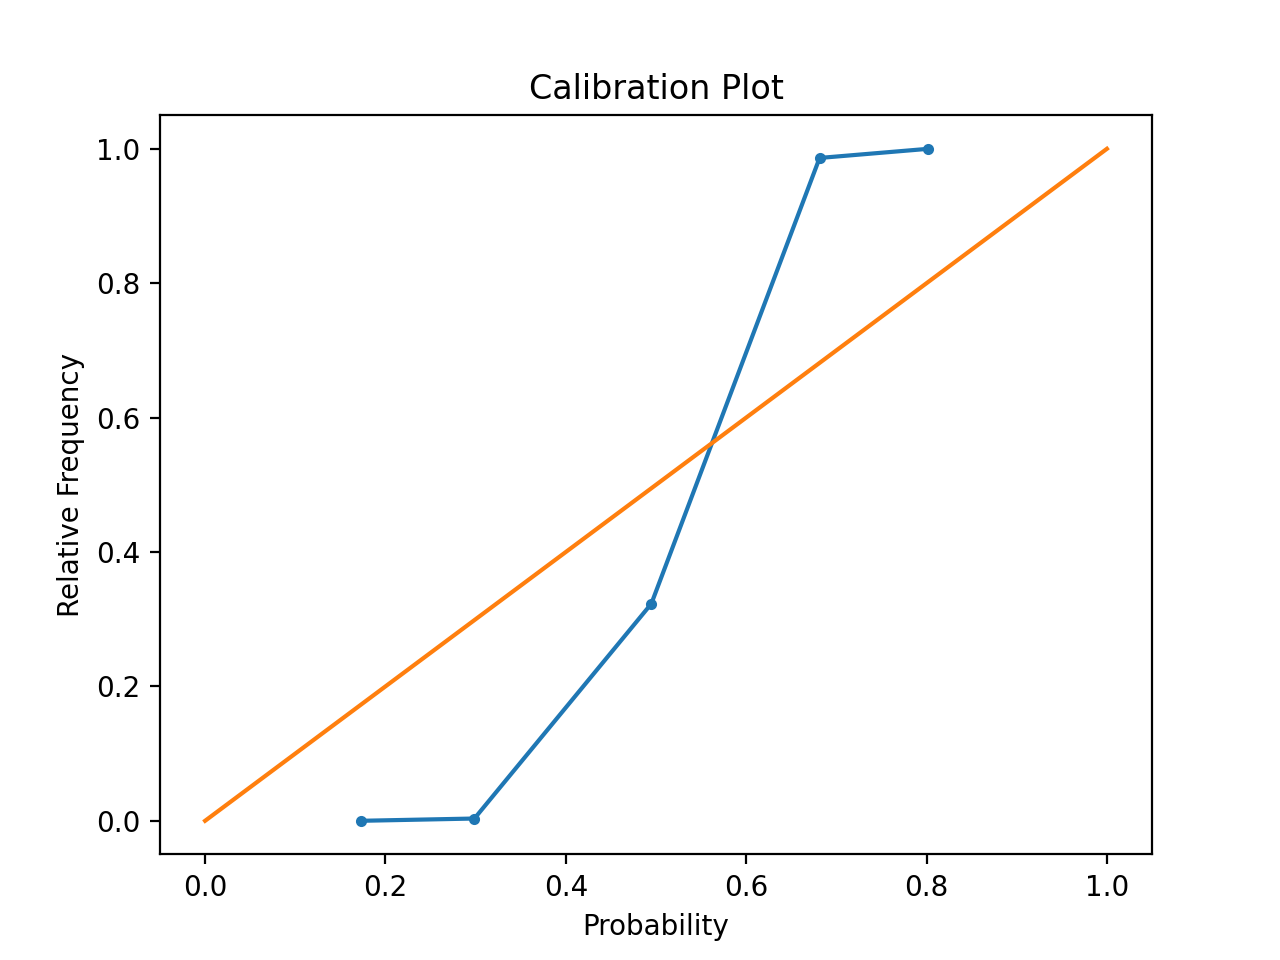

In [303]:
from sklearn.calibration import calibration_curve
samplesAvg = 0
with torch.no_grad():
    samplesAvg = predictive(COMPLETE_TEST_X)['obs'].detach().type(torch.float).mean(dim=0)
prob_true, prob_pred = calibration_curve(COMPLETE_TEST_Y, samplesAvg, n_bins=5)
fig, ax = plt.subplots()
ax.plot(prob_pred, prob_true, label="Clase", marker='.');
ax.set_xlabel("Probability")
ax.set_ylabel("Relative Frequency")
ax.set_title("Calibration Plot")
ax.plot(np.linspace(0, 1, 2),np.linspace(0, 1, 2), label='y = x');

De acuerdo al Uncertainty Calibration plot de arriba, el modelo bayesiano entrenado esta cercano a lo que se conoce como "Calibracion perfecta" pues la linea azul, que representa la confianza del modelo en las predicciones, esta muy cerca de la linea naranja, que reprenta una calibracion perfecta.

Entrando mas en detalle, el modelo parece tener una pequena inclinacion a estar "overconfident" acerca de las predicciones con baja probabilidad. Por el contrario, tambien para estar levemente "underconfident" en predicciones con una alta probabilidad. Esto significa que para predicciones en las que tiene baja probabilidad estima una probabilidad mayor de la que deberia y vice versa para el segundo caso.

<IPython.core.display.Javascript object>


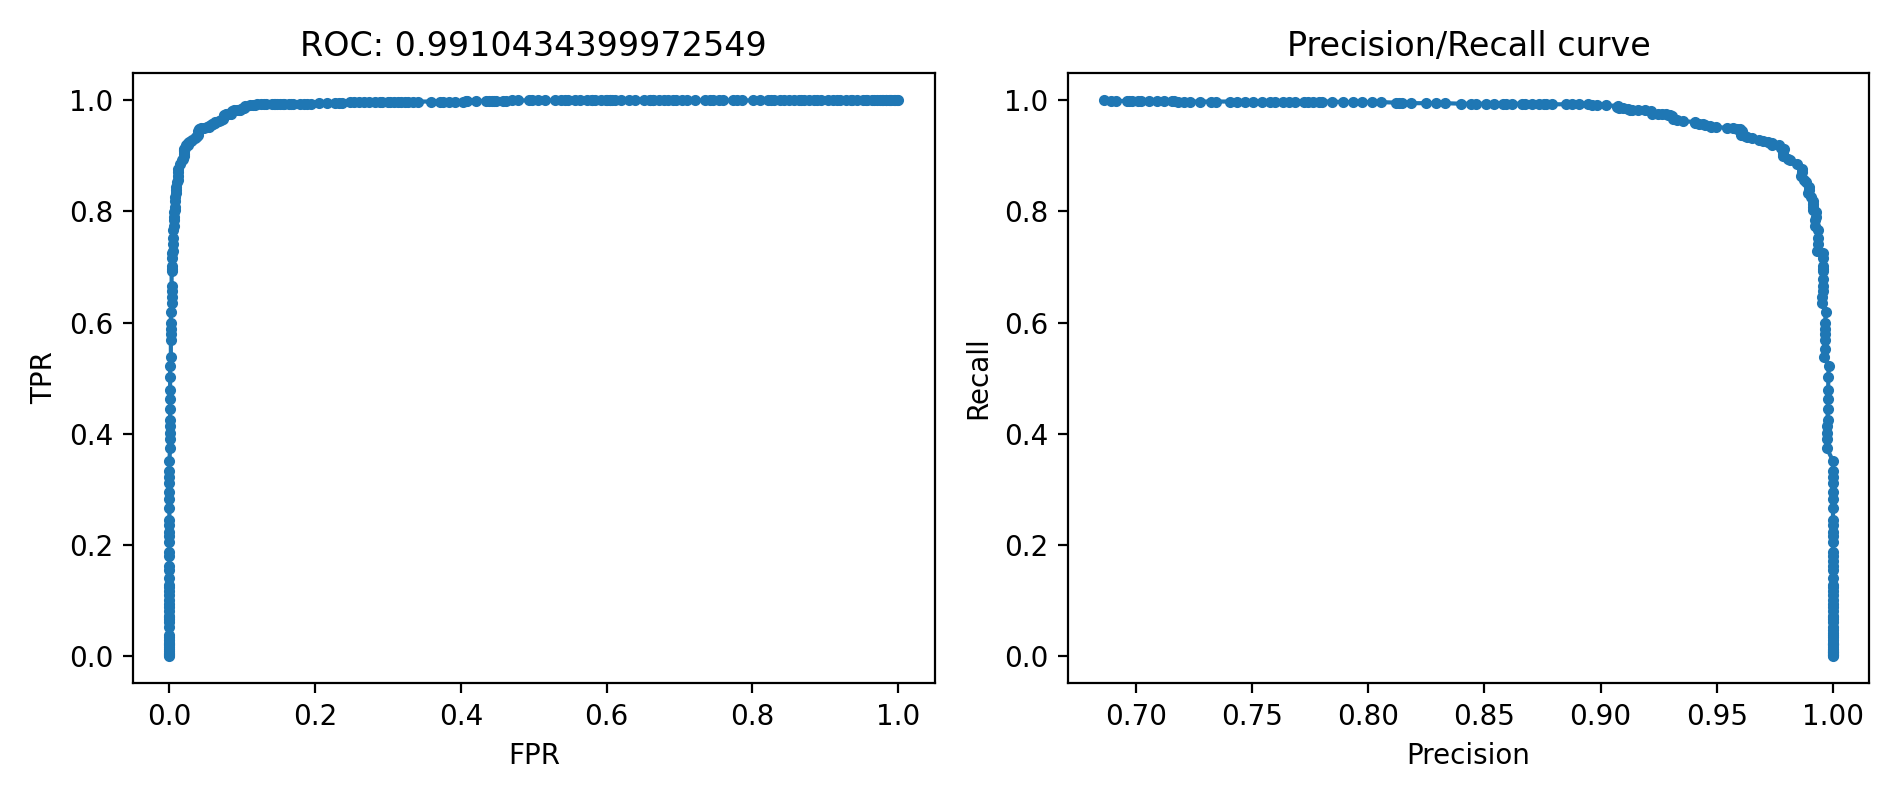

In [304]:
ns_fpr, ns_tpr, _ = roc_curve(COMPLETE_TEST_Y, samplesAvg)
pre, rec, _ = precision_recall_curve(COMPLETE_TEST_Y, samplesAvg)
roc = roc_auc_score(COMPLETE_TEST_Y, samplesAvg)

fig, ax = plt.subplots(1,2, figsize=(9.5, 4), tight_layout=True)
ax[0].plot(ns_fpr, ns_tpr, label="Clase", marker='.');
ax[0].set_xlabel("FPR")
ax[0].set_ylabel("TPR")
ax[0].set_title("ROC: {}".format(roc))

ax[1].plot(pre, rec, label="Clase", marker='.');
ax[1].set_xlabel("Precision")
ax[1].set_ylabel("Recall")
ax[1].set_title("Precision/Recall curve");


La curva FPR/TPR muestra resultados bastantes positivos. Con un ROC practicamente en 1. Esto quiere decir que al escoger el umbral correcto (0.5 en nuestro caso), practicamente no existe tradeoff entre clasificar correctamente las observaciones a coste de clasificar incorrectamente otras.
El grafico de la derecha muestra la curva Precision/Recall con resultados, nuevamente, bastante positivos. Con ambos valores cercanos a 1 con un umbral de 0.5.

In [305]:
print(classification_report(COMPLETE_TEST_Y, (samplesAvg.numpy() > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94       982
         1.0       0.92      0.98      0.95      1009

    accuracy                           0.95      1991
   macro avg       0.95      0.95      0.95      1991
weighted avg       0.95      0.95      0.95      1991

